# Career Success

Here we preprocess data and train a neural network for predicting starting salaray of individuals aged 18-30 given data about their education and experience. This model is then saved and used in a REST API for a possible frontend or other service to draw from.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. Data Preprocessing

In [2]:
df_cs = pd.read_csv('data/education_career_success.csv')
df_cs.dropna(inplace=True)
df_cs

,Student_ID,Age,Gender,High_School_GPA,SAT_Score,University_Ranking,University_GPA,Field_of_Study,Internships_Completed,Projects_Completed,Certifications,Soft_Skills_Score,Networking_Score,Job_Offers,Starting_Salary,Career_Satisfaction,Years_to_Promotion,Current_Job_Level,Work_Life_Balance,Entrepreneurship
0,S00001,24,Male,3.58,1052,291,3.96,Arts,3,7,2,9,8,5,27200.0,4,5,Entry,7,No
1,S00002,21,Other,2.52,1211,112,3.63,Law,4,7,3,8,1,4,25000.0,1,1,Mid,7,No
2,S00003,28,Female,3.42,1193,715,2.63,Medicine,4,8,1,1,9,0,42400.0,9,3,Entry,7,No
3,S00004,25,Male,2.43,1497,170,2.81,Computer Science,3,9,1,10,6,1,57400.0,7,5,Mid,5,No
4,S00005,22,Male,2.08,1012,599,2.48,Engineering,4,6,4,10,9,4,47600.0,9,5,Entry,2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,S04996,26,Female,2.44,1258,776,2.44,Arts,3,7,3,8,5,5,31500.0,9,5,Mid,7,No
4996,S04997,18,Female,3.94,1032,923,3.73,Law,0,9,3,6,4,5,41800.0,9,2,Entry,4,No
4997,S04998,19,Female,3.45,1299,720,2.52,Law,3,5,5,6,2,2,49500.0,2,5,Mid,6,No
4998,S04999,19,Male,2.70,1038,319,3.94,Law,1,4,5,5,1,5,54700.0,9,4,Entry,6,No


We select only features relating to educational history and experience as the focus is to only predict salaray for this exercise.

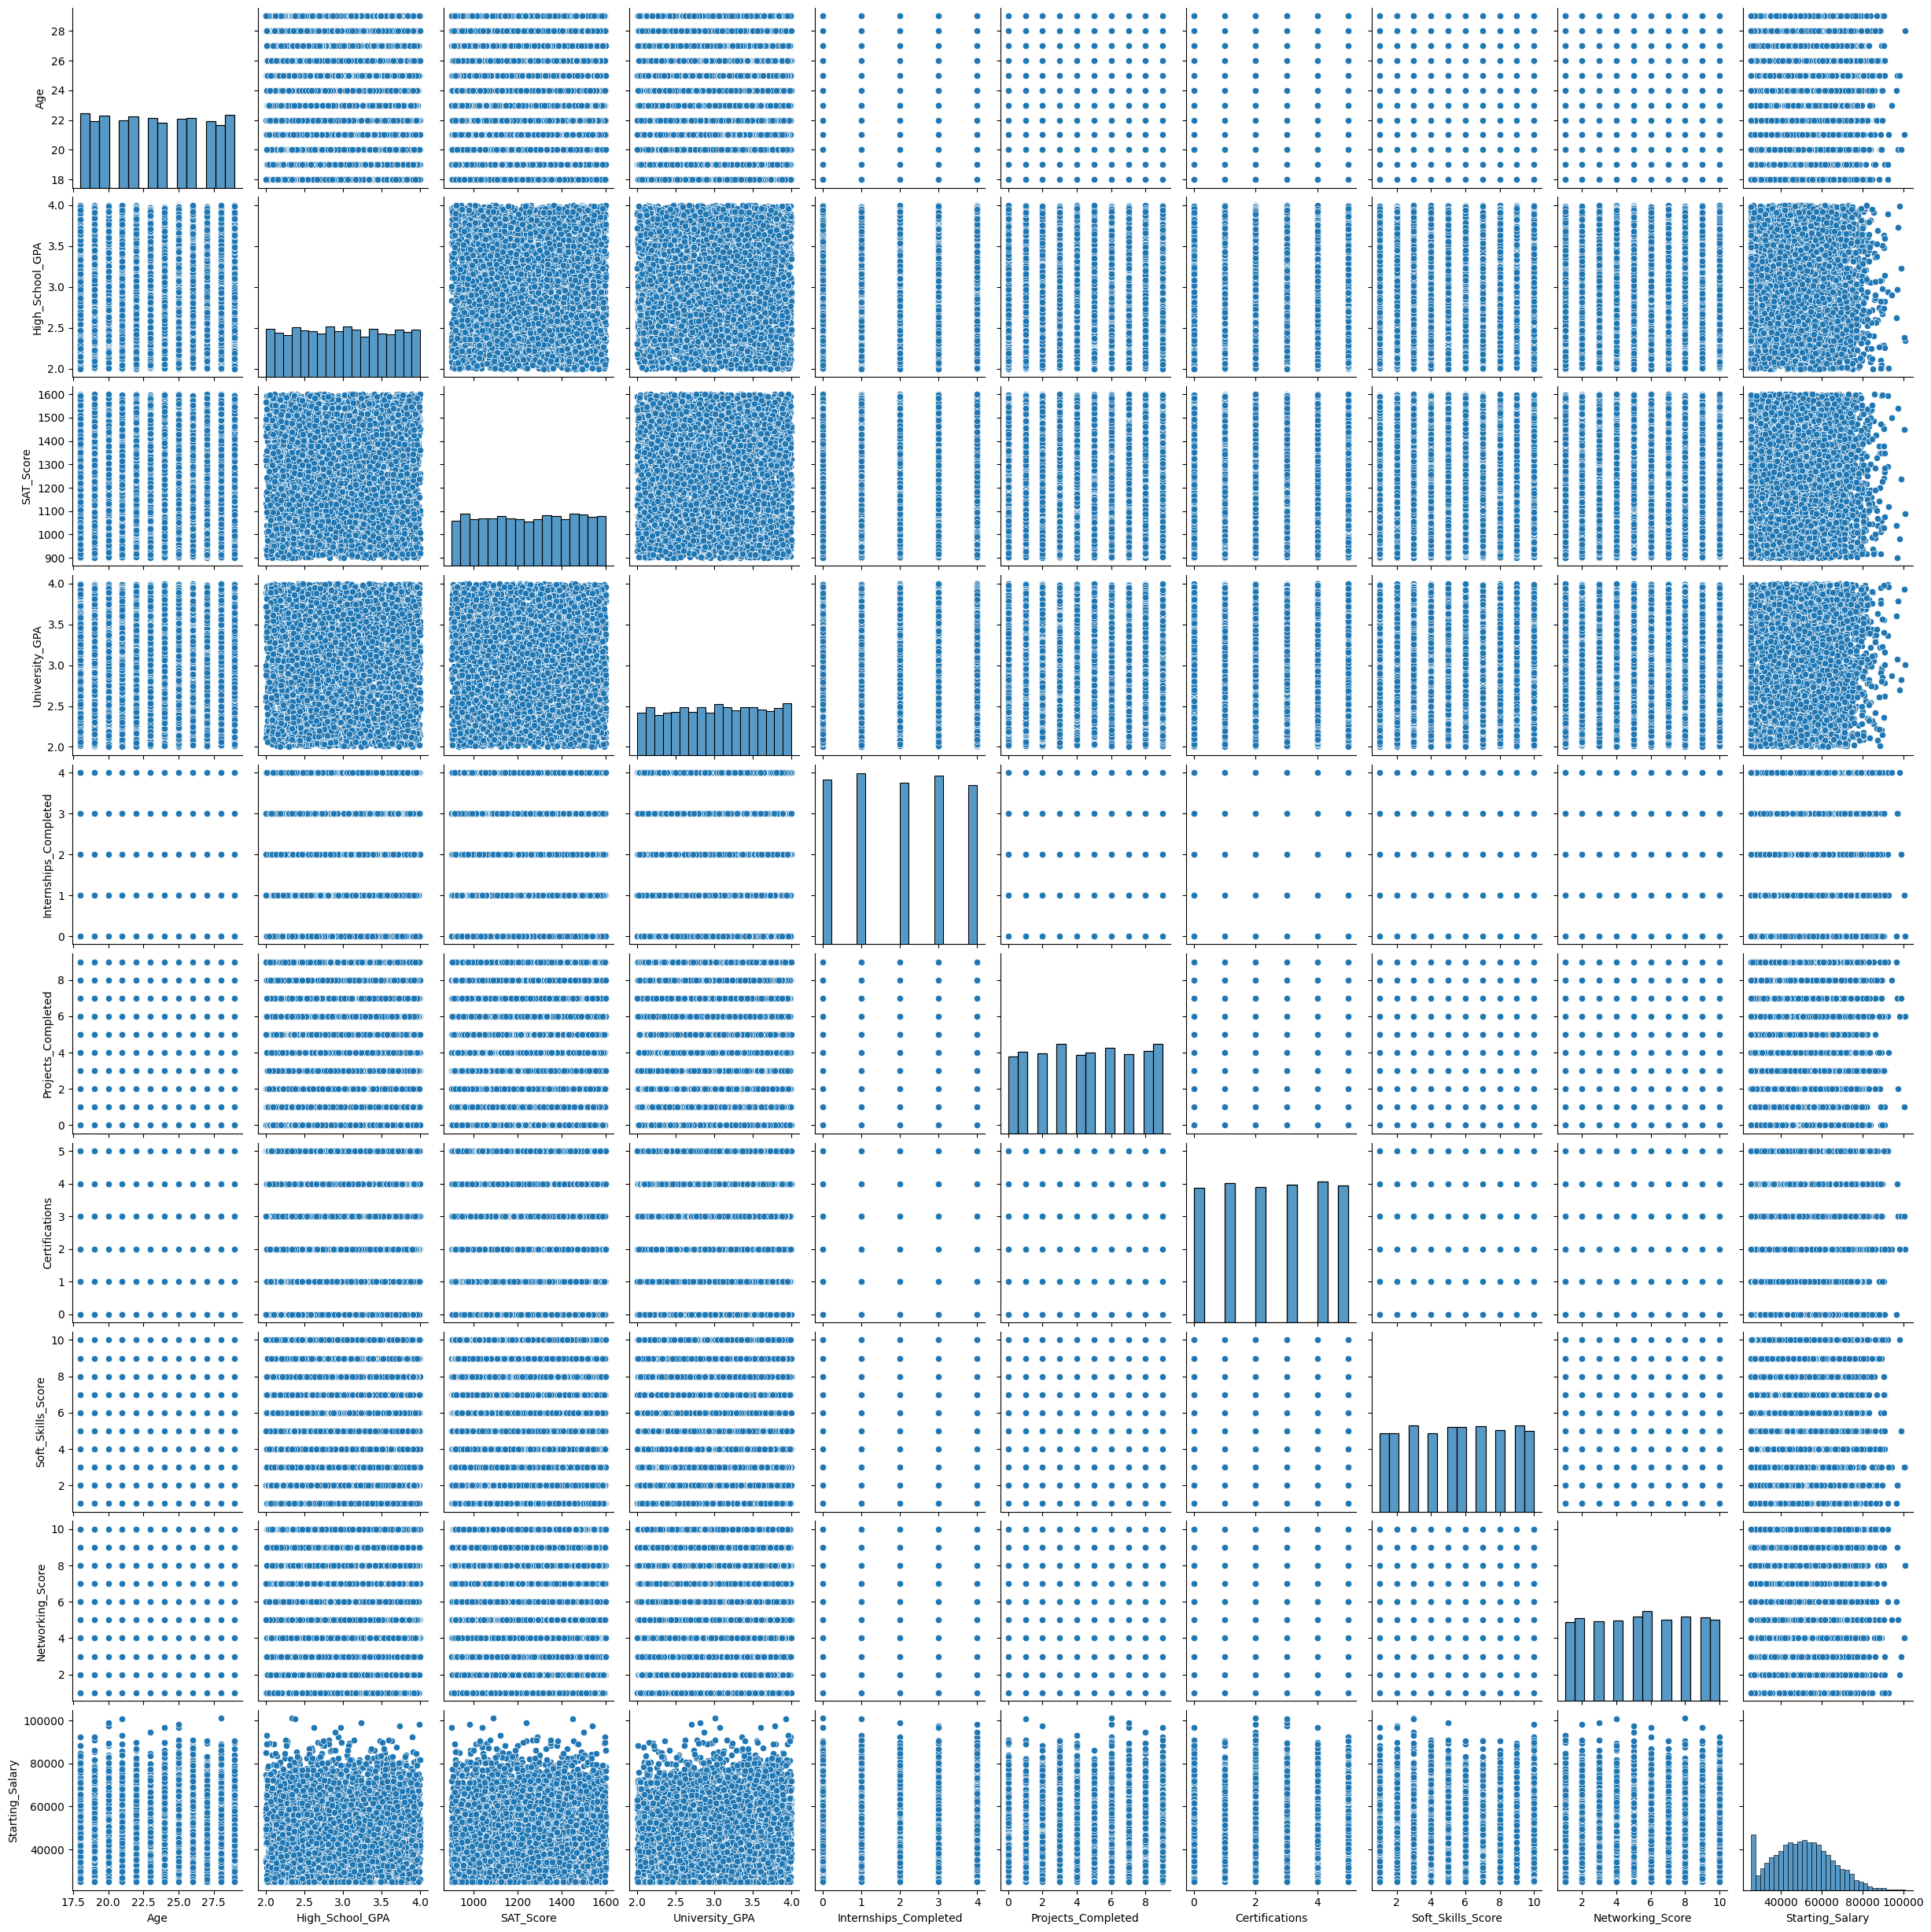

In [ ]:
# Select features that will be used for the model
df_model = df_cs[['Age', 'Gender', 'High_School_GPA', 'SAT_Score', 'University_GPA', 'Field_of_Study', 'Internships_Completed', 'Projects_Completed', 'Certifications', 'Soft_Skills_Score', 'Networking_Score', 'Starting_Salary']]

# Plot all features
sns.pairplot(df_model)
plt.show()

In [ ]:

# Encode categorical variables
df_model = pd.get_dummies(df_model, columns=['Gender', 'Field_of_Study'], dtype='int')
df_model

In [ ]:
# Scale features to train the neural network
df_model[['High_School_GPA','University_GPA']] = (df_model[['High_School_GPA','University_GPA']] - 0)/ (4 - 0)
df_model[['SAT_Score']] = (df_model[['SAT_Score']] - 400)/ (1600 - 400)
df_model[['Soft_Skills_Score', 'Networking_Score']] = (df_model[['Soft_Skills_Score', 'Networking_Score']] - 0)/ (10 - 0)
df_model[['Age']] = (df_model[['Age']] - 18)/ (30 - 18)

# Store normalisation parameters for manual testing
means = df_model[['Internships_Completed', 'Projects_Completed', 'Certifications']].mean()
stds = df_model[['Internships_Completed', 'Projects_Completed', 'Certifications']].std()
df_model[['Internships_Completed', 'Projects_Completed', 'Certifications']] = (df_model[['Internships_Completed', 'Projects_Completed', 'Certifications']] - means)/stds
df_model


#### 2. Model Training

In [ ]:
from sklearn.model_selection import train_test_split

y = df_model['Starting_Salary']
X = df_model.drop(['Starting_Salary'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the neural network
nn_model = keras.Sequential([
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=1)
])

# Select the training optimizer and loss function
nn_model.compile(
    optimizer='adam',
    loss='mae',
)

# Define callback to prevent unecessary training loop
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.1,
    restore_best_weights=True,
)

# Train the model
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=150,
    callbacks=[early_stopping],
)

# Plot training loss
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="MSE", xlabel='Epoch', ylabel='MSE')
# history_df.loc[:, ['mean_squared_error', 'val_mean_squared_error']].plot(title="MSE", xlabel='Epoch', ylabel='MSE')

In [ ]:
# Save the model
nn_model.save('../app/model_data/career_success_model.keras')

In [ ]:
nn_model.predict(X_valid.iloc[100].to_numpy().reshape(1, -1))[0]